# Phân khúc khách hàng & Phân tích hành vi E-commerce sử dụng RFM & K-Means

Notebook này triển khai dự án phân khúc khách hàng sử dụng mô hình **RFM (Recency, Frequency, Monetary)** và **K-Means Clustering**.

**Các bước thực hiện:**
1.  **Xử lý dữ liệu**: Làm sạch dữ liệu (loại bỏ đơn hàng hủy, giá trị null).
2.  **Feature Engineering**: Tạo các chỉ số RFM.
3.  **Chuẩn hóa**: Xử lý độ lệch và chuẩn hóa dữ liệu.
4.  **Mô hình hóa**: K-Means Clustering với phương pháp Elbow.
5.  **Trực quan hóa**: Biểu đồ phân tán 3D và Radar Chart cho insight kinh doanh.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import plotly.express as px
import plotly.graph_objects as go

# Thiết lập style
sns.set(style="whitegrid")

file_path = 'online+retail/Online Retail.xlsx'

print(f"Đang tải dữ liệu từ {file_path}...")
try:
    df = pd.read_excel(file_path)
    print("Tải dữ liệu thành công.")
    display(df.head())
    print(df.info())
except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy file tại {file_path}. Vui lòng kiểm tra lại đường dẫn.")

Đang tải dữ liệu từ online+retail/Online Retail.xlsx...
Tải dữ liệu thành công.


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None


## 1. Làm sạch & Tiền xử lý dữ liệu
- Loại bỏ các dòng thiếu `CustomerID`.
- Loại bỏ đơn hàng bị hủy (InvoiceNo bắt đầu bằng 'C').
- Loại bỏ các dòng có `Quantity` hoặc `UnitPrice` không hợp lệ.

In [2]:
# Loại bỏ các dòng thiếu CustomerID
df_clean = df.dropna(subset=['CustomerID'])

# Loại bỏ đơn hàng bị hủy (InvoiceNo bắt đầu bằng 'C')
df_clean = df_clean[~df_clean['InvoiceNo'].astype(str).str.startswith('C')]

# Loại bỏ các bản ghi có Số lượng hoặc Đơn giá âm (để đảm bảo an toàn)
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]

print(f"Kích thước ban đầu: {df.shape}")
print(f"Kích thước sau khi làm sạch: {df_clean.shape}")

Kích thước ban đầu: (541909, 8)
Kích thước sau khi làm sạch: (397884, 8)


## 2. Feature Engineering: Chỉ số RFM

- **Recency (R)**: Số ngày kể từ lần mua cuối cùng.
- **Frequency (F)**: Số lượng hóa đơn duy nhất.
- **Monetary (M)**: Tổng chi tiêu.

In [3]:
# Tính Tổng tiền cho giá trị Monetary
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']

# Xác định ngày tham chiếu (1 ngày sau giao dịch cuối cùng trong bộ dữ liệu)
ref_date = df_clean['InvoiceDate'].max() + dt.timedelta(days=1)

# Nhóm theo CustomerID để tính RFM
rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days, # Recency
    'InvoiceNo': 'nunique',                             # Frequency
    'TotalPrice': 'sum'                                 # Monetary
}).reset_index()

# Đổi tên cột
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)

display(rfm.head())
print(rfm.describe())

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


         CustomerID      Recency    Frequency       Monetary
count   4338.000000  4338.000000  4338.000000    4338.000000
mean   15300.408022    92.536422     4.272015    2054.266460
std     1721.808492   100.014169     7.697998    8989.230441
min    12346.000000     1.000000     1.000000       3.750000
25%    13813.250000    18.000000     1.000000     307.415000
50%    15299.500000    51.000000     2.000000     674.485000
75%    16778.750000   142.000000     5.000000    1661.740000
max    18287.000000   374.000000   209.000000  280206.020000


## 3. Chuẩn hóa & Chuyển đổi
Dữ liệu RFM thường bị lệch (ví dụ: nhiều người chi tiêu thấp, ít người chi tiêu cao) -> Sử dụng Log Transformation để giảm độ lệch

In [4]:
# Kiểm tra độ lệch
print("Độ lệch trước khi chuyển đổi:")
print(rfm[['Recency', 'Frequency', 'Monetary']].skew())

# Log Transformation (cộng 1 để tránh log(0))
rfm_log = np.log1p(rfm[['Recency', 'Frequency', 'Monetary']])

# Chuẩn hóa Standard Scaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])

print("\nĐộ lệch sau khi chuyển đổi log:")
print(pd.DataFrame(rfm_log, columns=['Recency', 'Frequency', 'Monetary']).skew())

display(rfm_scaled_df.head())

Độ lệch trước khi chuyển đổi:
Recency       1.246048
Frequency    12.067031
Monetary     19.324953
dtype: float64

Độ lệch sau khi chuyển đổi log:
Recency     -0.379169
Frequency    1.208652
Monetary     0.393553
dtype: float64


,Recency,Frequency,Monetary
0,1.461993,-0.955214,3.706225
1,-2.038734,1.074425,1.411843
2,0.373104,0.386304,0.716489
3,-0.623086,-0.955214,0.698739
4,1.424558,-0.955214,-0.618962


## 4. Mô hình hóa: K-Means Clustering
### Phương pháp Elbow
Tìm số lượng cụm tối ưu ($k$).

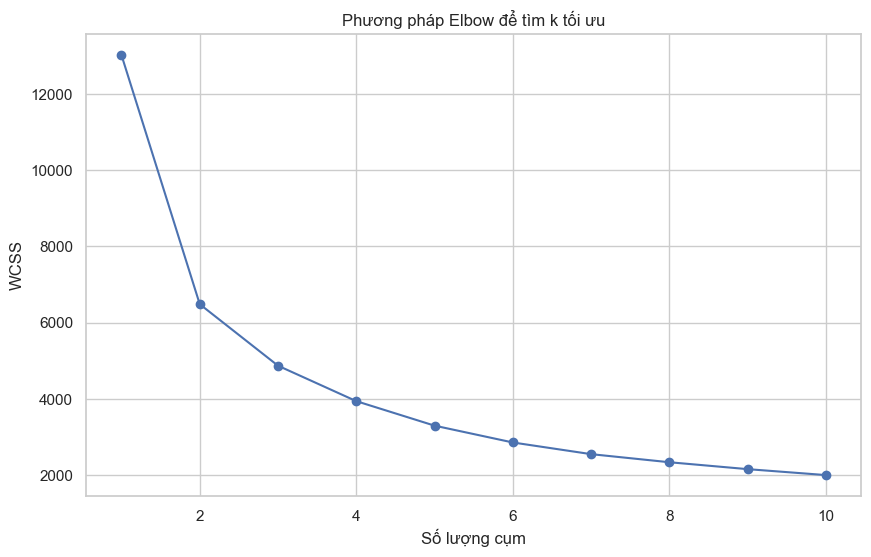

In [5]:
wcss = []
range_n_clusters = range(1, 11)

for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled_df)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, wcss, marker='o')
plt.title('Phương pháp Elbow để tìm k tối ưu')
plt.xlabel('Số lượng cụm')
plt.ylabel('WCSS')
plt.show()

### Huấn luyện K-Means
Dựa trên biểu đồ Elbow, chúng ta thường chọn điểm "khuỷu tay" (Điểm WCSS giảm chậm dần).

In [ ]:
# Huấn luyện K-Means với k=6
k = 6
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans.fit(rfm_scaled_df)

# Gán nhãn cho dữ liệu gốc
rfm['Cluster'] = kmeans.labels_

## 5. Trực quan hóa & Insight
### Biểu đồ phân tán 3D (3D Scatter Plot)

In [48]:
fig = px.scatter_3d(rfm, x='Recency', y='Frequency', z='Monetary',
                    color='Cluster', opacity=0.7,
                    title='Biểu đồ phân tán 3D phân khúc khách hàng',
                    labels={'Recency': 'Recency (ngày)', 'Frequency': 'Frequency (lần)', 'Monetary': 'Monetary ($)'})
fig.show()

### Biểu đồ Snake Plot

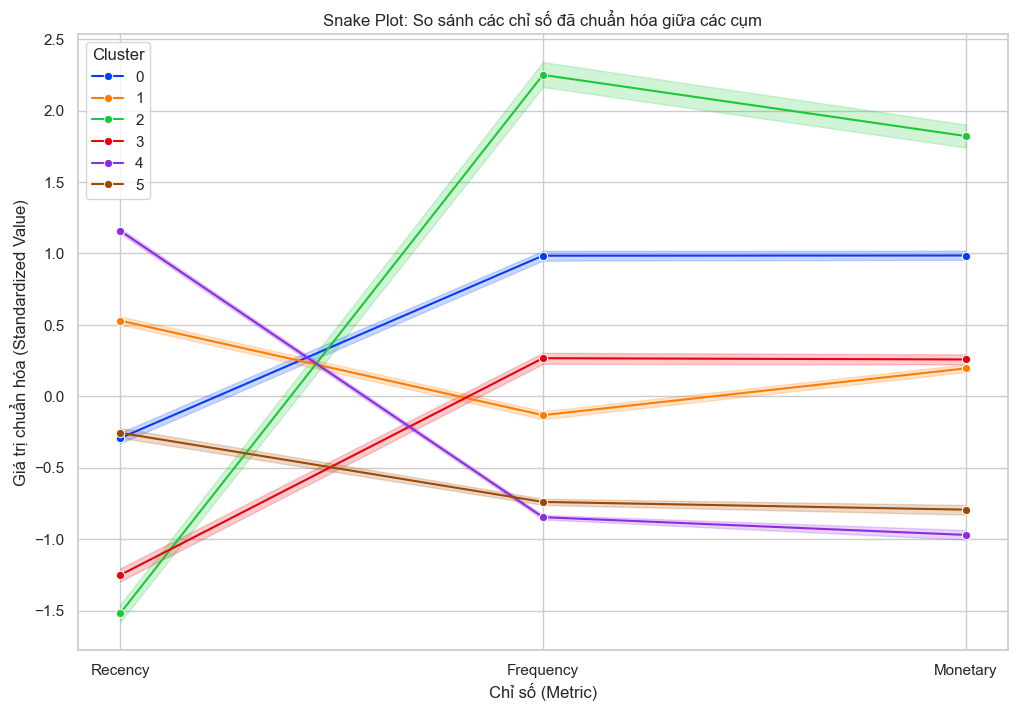

Tóm tắt cụm:


,Cluster,Recency,Frequency,Monetary,CustomerID
0,0,38.835067,6.913819,3047.266805,673
1,1,112.008421,2.671579,1162.766351,950
2,2,7.271341,20.634146,13841.472073,328
3,3,10.155668,3.861252,1192.748545,591
4,4,233.364191,1.192269,259.764832,983
5,5,38.247232,1.376384,314.518144,813


In [50]:
# Chuẩn bị dữ liệu cho Snake Plot
# Tạo DataFrame chứa dữ liệu đã chuẩn hóa và nhãn cụm từ rfm gốc
rfm_snake = rfm_scaled_df.copy()
rfm_snake['Cluster'] = rfm['Cluster']

# Melt dữ liệu về dạng long format để vẽ biểu đồ line
rfm_melt = pd.melt(rfm_snake.reset_index(),
                    id_vars=['Cluster'],
                    value_vars=['Recency', 'Frequency', 'Monetary'],
                    var_name='Metric',
                    value_name='Value')

# Vẽ Snake Plot
plt.figure(figsize=(12, 8))
sns.lineplot(data=rfm_melt, x='Metric', y='Value', hue='Cluster', palette='bright', marker='o')
plt.title('Snake Plot: So sánh các chỉ số đã chuẩn hóa giữa các cụm')
plt.xlabel('Chỉ số (Metric)')
plt.ylabel('Giá trị chuẩn hóa (Standardized Value)')
plt.legend(title='Cluster')
plt.show()

# Phân tích giá trị trung bình của cụm
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',    # Tính trung bình ngày
    'Frequency': 'mean',  # Tính trung bình tần suất
    'Monetary': 'mean',   # Tính trung bình tiền
    'CustomerID': 'count' # Đếm số khách hàng trong cụm
}).reset_index()

print("Tóm tắt cụm:")
display(cluster_summary)

### Gán nhãn tự động (Auto-Labeling)
Quy tắc: **Điểm = Frequency + Monetary - Recency** (Vì Recency càng thấp càng tốt).
Nhóm có điểm cao nhất sẽ là "VIP", thấp nhất là "Rời bỏ".

Thứ tự xếp hạng cụm (Cluster ID) từ tốt nhất -> kém nhất:
[2, 0, 3, 1, 5, 4]

Bảng phân khúc khách hàng (Đã gán nhãn):


,Recency,Frequency,Monetary,CustomerID
Segment,,,,
VIP (Kim cương),7.27,20.63,13841.47,328
Trung thành (Vàng),38.84,6.91,3047.27,673
Tiềm năng (Bạc),10.16,3.86,1192.75,591
Mới / Ít mua,112.01,2.67,1162.77,950
Nguy cơ rời bỏ,38.25,1.38,314.52,813
Đã rời bỏ,233.36,1.19,259.76,983


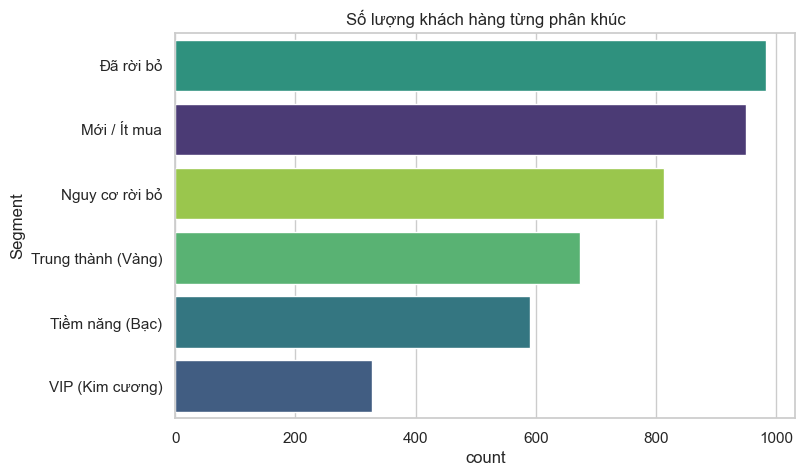

In [ ]:
# 1. Tính điểm xếp hạng dựa trên dữ liệu đã chuẩn hóa
rfm_scaled_temp = rfm_scaled_df.copy()
rfm_scaled_temp['Cluster'] = rfm['Cluster']
means = rfm_scaled_temp.groupby('Cluster').mean()

# Score = F + M - R (R càng nhỏ càng tốt nên mang dấu trừ)
scores = means['Frequency'] + means['Monetary'] - means['Recency']
scores = scores.sort_values(ascending=False)

print("Thứ tự xếp hạng cụm (Cluster ID) từ tốt nhất -> kém nhất:")
print(scores.index.tolist())

# 2. Định nghĩa tên nhóm theo thứ tự xếp hạng
# Tùy vào số lượng k mà ta có bộ tên phù hợp
if k == 4:
    names = ['VIP (Kim cương)', 'Trung thành (Vàng)', 'Tiềm năng (Bạc)', 'Rời bỏ / Ngủ đông']
elif k == 6:
    names = ['VIP (Kim cương)', 'Trung thành (Vàng)', 'Tiềm năng (Bạc)', 'Mới / Ít mua', 'Nguy cơ rời bỏ', 'Đã rời bỏ']
else:
    names = [f'Hạng {i+1}' for i in range(k)]

# 3. Map Cluster ID sang Tên
mapping = {cluster_id: names[i] for i, cluster_id in enumerate(scores.index) if i < len(names)}

rfm['Segment'] = rfm['Cluster'].map(mapping)

# 4. Xem kết quả phân nhóm mới
segment_summary = rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).sort_values('Monetary', ascending=False)

print("\nBảng phân khúc khách hàng (Đã gán nhãn):")
display(segment_summary.round(2))

plt.figure(figsize=(8, 5))
sns.countplot(y='Segment', data=rfm, hue='Segment', order=rfm['Segment'].value_counts().index, palette='viridis', legend=False)
plt.title('Số lượng khách hàng từng phân khúc')
plt.show()